# 05. Transfer Learning with TensorFlow Part 2: Fine-tunning

In then previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine tunning

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we cold rewrite them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

In [3]:
# Get helper_functions.py script from GitHub
!wget https://raw.githubusercontent.com/GusTiavo123/deep-learning/main/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, unzip_data, walk_through_dir, plot_loss_curves

--2024-02-13 17:55:37--  https://raw.githubusercontent.com/GusTiavo123/deep-learning/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10245 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.00K  --.-KB/s    in 0s      

2024-02-13 17:55:37 (88.1 MB/s) - ‘helper_functions.py.2’ saved [10245/10245]



In [2]:
import sys
from contextlib import contextmanager

# Define a context manager to temporarily add a path to sys.path
@contextmanager
def temporary_sys_path_append(path):
    sys.path.append(path)  # Add the specified path to sys.path
    try:
        yield  # Allow code within the with-block to execute
    finally:
        # Ensure the path is removed after exiting the with-block
        sys.path.remove(path)

# Using the context manager to temporarily add a path to sys.path
with temporary_sys_path_append('..'):
    # Inside this block, you can import modules located in the added path
    from helper_functions import create_tensorboard_callback, unzip_data, walk_through_dir, plot_loss_curves
    # Use the function or perform actions with the imported module here

# Outside the with-block, the path is no longer in sys.path, limiting the change to the block


## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food)

In [4]:
# Get 10% of the data of the 10 classes food photos

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2024-02-13 17:55:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.207, 172.217.194.207, 142.250.4.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  22.6MB/s    in 8.1s    

2024-02-13 17:56:07 (19.8 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
unzip_data("10_food_classes_10_percent.zip")

In [3]:
# Walkthrough 10 percent data directory and list number of files
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [2]:
# Create training a test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [3]:
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
# Check out the classes names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight-foward, it turns our layers in sequential order.

But the functional API gives us more flexibility with our models.

In [6]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

In [7]:
# 2. Freeze the base model
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like ResNet50v2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most importan information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)


In [8]:
# 9. Compile the model
model_0.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="categorical_crossentropy",
                metrics= ["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=len(test_data),
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20240214-153849
Epoch 1/5
24/24 [==============================] - 55s 2s/step - loss: 1.8364 - accuracy: 0.4293 - val_loss: 1.2939 - val_accuracy: 0.7212
Epoch 2/5
24/24 [==============================] - 39s 2s/step - loss: 1.1323 - accuracy: 0.7293 - val_loss: 0.8865 - val_accuracy: 0.7948
Epoch 3/5
24/24 [==============================] - 38s 2s/step - loss: 0.8326 - accuracy: 0.8133 - val_loss: 0.7092 - val_accuracy: 0.8320
Epoch 4/5
24/24 [==============================] - 37s 2s/step - loss: 0.6814 - accuracy: 0.8507 - val_loss: 0.6182 - val_accuracy: 0.8452
Epoch 5/5
24/24 [==============================] - 36s 2s/step - loss: 0.5854 - accuracy: 0.8707 - val_loss: 0.5628 - val_accuracy: 0.8520


In [15]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer)

0 <keras.engine.input_layer.InputLayer object at 0x000001E141A53670>
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x000001E141716CB0>
2 <keras.layers.preprocessing.normalization.Normalization object at 0x000001E1418942E0>
3 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001E141717520>
4 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001E141896500>
5 <keras.layers.core.activation.Activation object at 0x000001E141895BA0>
6 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001E141E00880>
7 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001E141E00550>
8 <keras.layers.core.activation.Activation object at 0x000001E141E008E0>
9 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001E141E01C30>
10 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001E141E03280>
11 <keras.layers.core.activation.Activation object at 0x000001E141E03EB0>
12 <keras.lay

In [16]:
# Check the summary of our base model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


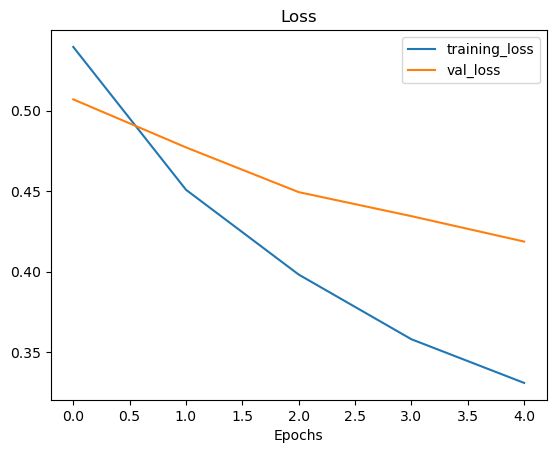

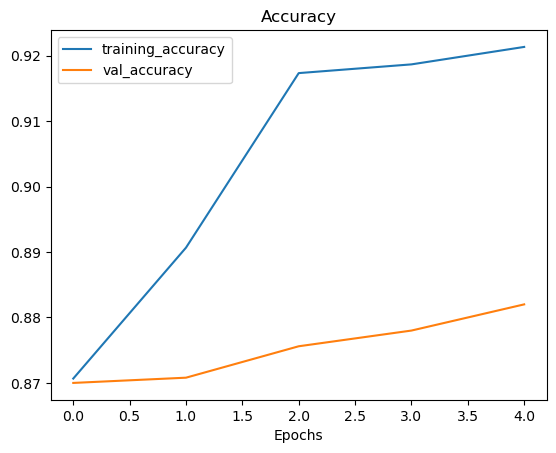

In [17]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vectore from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after  our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through `GlobalAveragePooling2D`, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to `GlobalAveragePooling2D`

In [18]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: \n {input_tensor}")

Random input tensor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]


In [19]:
# Pass the random tensor to a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}")

2D global average pooled random tensor:
 [[-0.09368646 -0.45840445 -0.28855976]]


> 🔑**Note:** One of the reasons feature extraction transfer learning is named how it is is because what often happens is pretrained model outputs a **feature vector** (a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()`layer) which can then be used to extract patterns out of for own specific problem.

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out: 

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer lerning with 10% of the training data with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer leraning on 100% of the training data with data augmentation

>🔑**Note:** throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

### Getting and preprocessing data for model_1

In [ ]:
# Download - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

In [5]:
# Unzip data
unzip_data("10_food_classes_1_percent.zip")

In [6]:
# Walkthrough 10_food_classes_1_percent
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

In [11]:
# Create training a test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [12]:
# Setup data loaders
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation rigth into the model

To add data augmentation rigth into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

The benefits of using data augmentation insade the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather tan the CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [4]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./225) Keep for models like ResNet50v2
], name="data_augmentation")

### Visiaulize our data augmentation layer (and see what happens to our data)

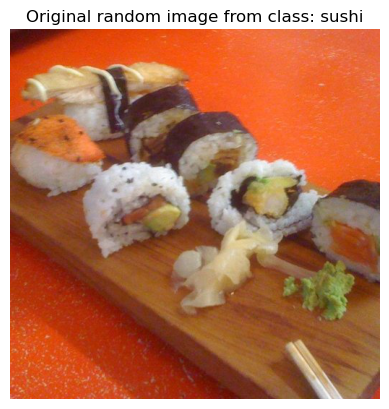

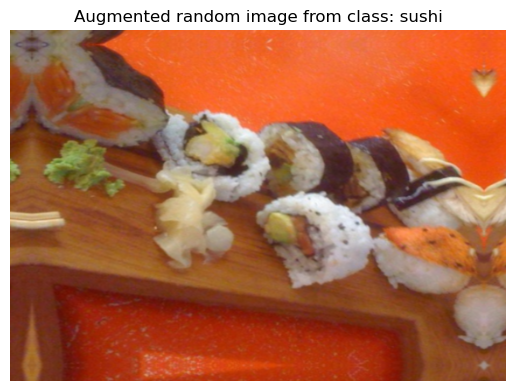

In [14]:
# View a random image a compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False)

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0), training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)


import logging
tf.get_logger().setLevel(logging.ERROR) # Used it to not show warnings

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [25]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and dont train it
x = base_model(x, training=False)

# Pool output features of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer as the output
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Create the model
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data_1_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_1_percent),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240215-175145
Epoch 1/5
3/3 [==============================] - 55s 20s/step - loss: 2.3459 - accuracy: 0.0857 - val_loss: 2.1974 - val_accuracy: 0.2232
Epoch 2/5
3/3 [==============================] - 39s 19s/step - loss: 2.0943 - accuracy: 0.2429 - val_loss: 2.0735 - val_accuracy: 0.2768
Epoch 3/5
3/3 [==============================] - 40s 19s/step - loss: 1.9012 - accuracy: 0.4429 - val_loss: 1.9584 - val_accuracy: 0.3288
Epoch 4/5
3/3 [==============================] - 40s 20s/step - loss: 1.7280 - accuracy: 0.5429 - val_loss: 1.8524 - val_accuracy: 0.3912
Epoch 5/5
3/3 [==============================] - 39s 19s/step - loss: 1.5619 - accuracy: 0.6714 - val_loss: 1.7532 - val_accuracy: 0.4628


In [26]:
# Check out our model summary
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

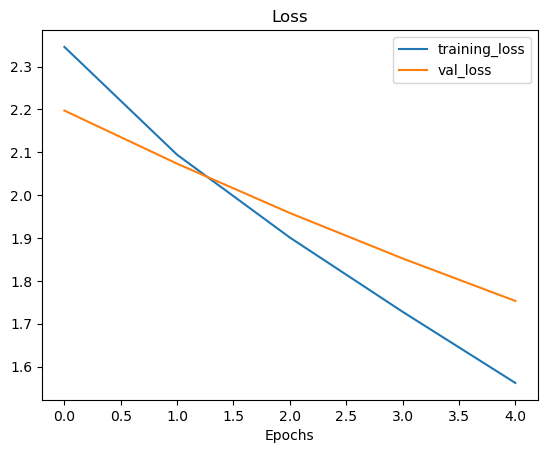

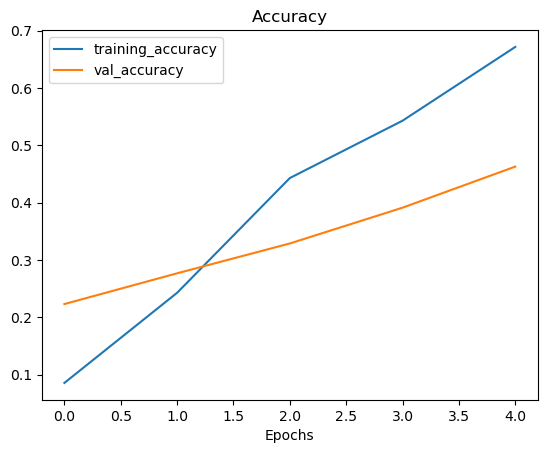

In [27]:
plot_loss_curves(history=history_1)

## Model 2: Feature extraction transfer learning on 10% of the data with data augmentation

In [6]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and dont train it
x = base_model(x, training=False)

# Pool output features of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer as the output
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Create the model
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

### Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [8]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint"

# Create a ModelCheckpoint callback that saves the model's weigths only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1)

### Fit model 2 passing in the ModelCheckpoint callback

In [15]:
# Fit the model using ModelCheckpoint callback
initial_epochs = 5
history_2  = model_2.fit(train_data_10_percent,
                         epochs=initial_epochs,
                         steps_per_epoch=len(train_data_10_percent),
                         validation_data=test_data,
                         validation_steps=int(0.25 * len(test_data)),
                         callbacks=[create_tensorboard_callback("transfer_learning",
                                                                "10_percent_data_aug"),
                                    checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240216-135917
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9989 - accuracy: 0.3480
Epoch 1: saving model to ten_percent_model_checkpoints_weights\checkpoint
24/24 [==============================] - 32s 976ms/step - loss: 1.9989 - accuracy: 0.3480 - val_loss: 1.4839 - val_accuracy: 0.6447
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3103 - accuracy: 0.6933
Epoch 2: saving model to ten_percent_model_checkpoints_weights\checkpoint
24/24 [==============================] - 21s 907ms/step - loss: 1.3103 - accuracy: 0.6933 - val_loss: 1.0360 - val_accuracy: 0.7599
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0255 - accuracy: 0.7560
Epoch 3: saving model to ten_percent_model_checkpoints_weights\checkpoint
24/24 [==============================] - 23s 960ms/step - loss: 1.0255 - accuracy: 0.7560 - val_loss: 0.8293 - val_accuracy: 0.7878
Epoch 4/5
24/24 

In [16]:
# Check model 2 results on all test_data
model_2.evaluate(test_data)

79/79 [==============================] - 34s 427ms/step - loss: 0.6293 - accuracy: 0.8436


[0.6293181777000427, 0.8435999751091003]

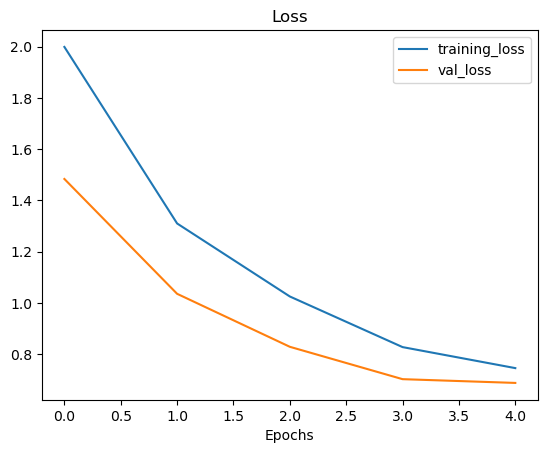

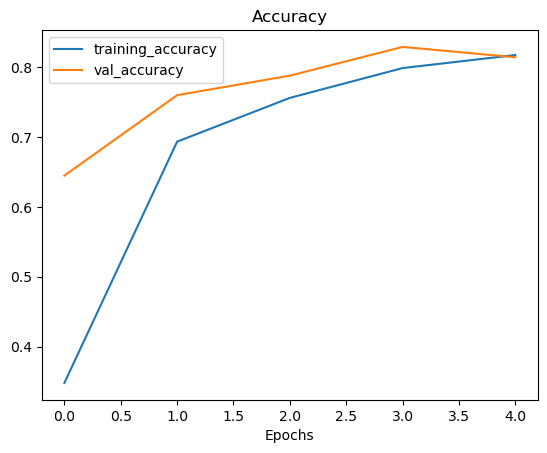

In [17]:
# Plot model loss curves
plot_loss_curves(history_2)

### Loading in checkpointed weights

Loading in checkpointed weights returns a mdoel to a specific checkpoint

In [18]:
# Load in saved model weigths
model_2.load_weights(checkpoint_path)

In [19]:
# Evaluate model_2 with loaded weights
model_2.evaluate(test_data)

79/79 [==============================] - 39s 486ms/step - loss: 0.6293 - accuracy: 0.8436


[0.629318118095398, 0.8435999751091003]

## Model 3: Fine-tunning an existing model on 10% of the data

>🔑**Note:** Fine-tunning usually works best *after* training feature extraction model for a few epochs with large amounts of custom data.

In [20]:
# Layers in loaded model
model_2.layers

In [22]:
# Are these layers trainable?
for layer in model_2.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x00000251430095D0> True
<keras.engine.sequential.Sequential object at 0x0000025142D02620> True
<keras.engine.functional.Functional object at 0x0000025145D61D50> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x0000025145418B80> True
<keras.layers.core.dense.Dense object at 0x00000251454188B0> True


In [23]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine tuning you typically want to lower the learning rate by 10x
                loss="categorical_crossentropy",
                metrics=["accuracy"])

>🔑**Note:** When using fine-tuning it's best practice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is at least 10x (though different sources will claim other values).
A good resource for information on this is the [ULMFIT](https://arxiv.org/abs/1801.06146) paper

In [24]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [25]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_2_tune = model_2.fit(train_data_10_percent,
                             epochs=fine_tune_epochs,
                             validation_data=test_data,
                             validation_steps=int(0.25 * len(test_data)),
                             initial_epoch=history_2.epoch[-1], # start training from the last epoch
                             callbacks=[create_tensorboard_callback("transfer_learning",
                                                                    "10_percent_fine_tune_last10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last10/20240216-145402
Epoch 5/10
24/24 [==============================] - 43s 1s/step - loss: 0.6224 - accuracy: 0.8253 - val_loss: 0.5119 - val_accuracy: 0.8388
Epoch 6/10
24/24 [==============================] - 26s 1s/step - loss: 0.4934 - accuracy: 0.8627 - val_loss: 0.4960 - val_accuracy: 0.8405
Epoch 7/10
24/24 [==============================] - 27s 1s/step - loss: 0.4254 - accuracy: 0.8787 - val_loss: 0.4840 - val_accuracy: 0.8355
Epoch 8/10
24/24 [==============================] - 26s 1s/step - loss: 0.3906 - accuracy: 0.8893 - val_loss: 0.4899 - val_accuracy: 0.8454
Epoch 9/10
24/24 [==============================] - 26s 1s/step - loss: 0.3588 - accuracy: 0.8933 - val_loss: 0.4839 - val_accuracy: 0.8520
Epoch 10/10
24/24 [==============================] - 26s 1s/step - loss: 0.3233 - accuracy: 0.9040 - val_loss: 0.4812 - val_accuracy: 0.8569


In [27]:
# Evaluate the fine-tuned model_2
model_2.evaluate(test_data)

79/79 [==============================] - 40s 504ms/step - loss: 0.4174 - accuracy: 0.8668


[0.4174087345600128, 0.8668000102043152]

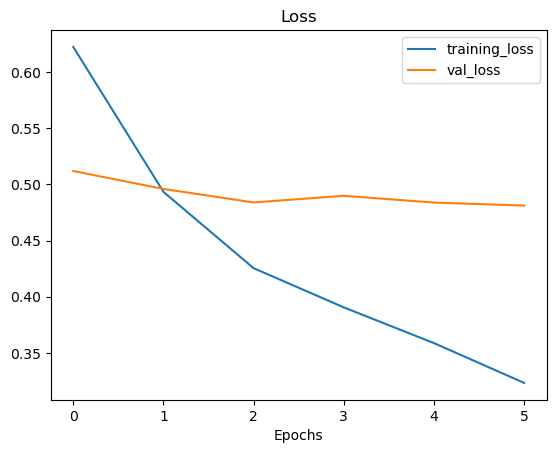

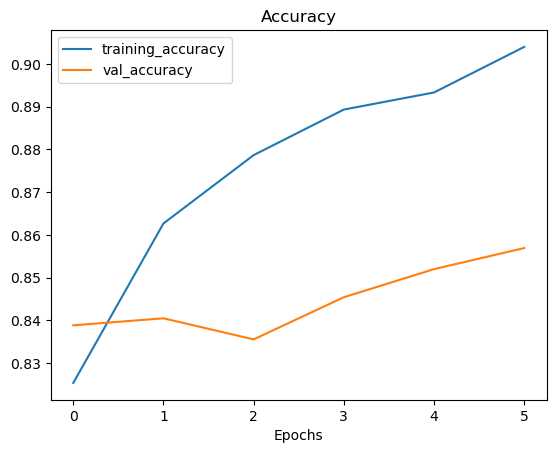

In [28]:
plot_loss_curves(history_2_tune)

The `plot_loss_curves` function works great with models wich have only been fit once, however, we want something to compare on series of running `fit()` with another (e.g. before and after fine-tunning)

In [37]:
# Let's create a function to compare training historys
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow History objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history metrics with new_history metrics
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots for accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label="Training Accuracy")
    plt.plot(total_val_acc, label="Val Accuracy")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    # Make plots for loss
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label="Training loss")
    plt.plot(total_val_loss, label="Val loss")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Accuracy")

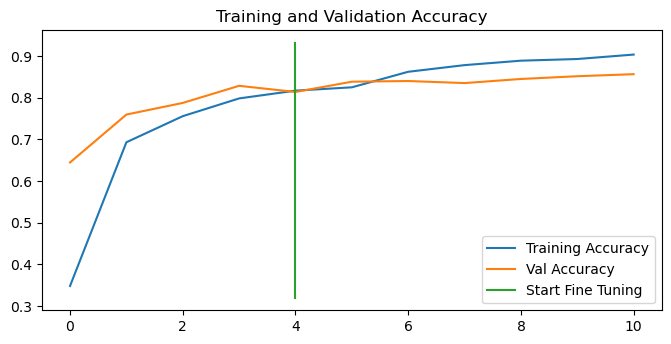

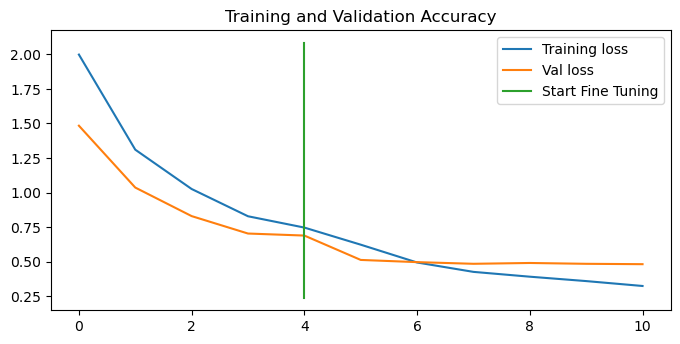

In [38]:
compare_historys(history_2,
                 history_2_tune,
                 5)

## Model 4: Fine-tuning and existing model on all of the data

In [ ]:
# Dowload 100% of training data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

In [39]:
# Unzip 100% of training data
unzip_data("10_food_classes_all_data.zip")

In [40]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [41]:
# How many images are we working
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data\test'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\steak'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\sushi'.
There are 

In [42]:
# Setup data inputs
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


to train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights.

In [43]:
# Load weights from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

In [44]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 53s 471ms/step - loss: 0.6293 - accuracy: 0.8436


[0.6293181777000427, 0.8435999751091003]

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weights using `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with te top 10 layers of the base model unfrozen (model_3)
3. Saved the results and training logs each time
4. Reloaded the same model from step 1 to do the same steps as step 2 except this time we're going to use all of the data (model_4)

In [45]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [49]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [50]:
# Continue to train and fine-tune the model to our data (100% of the training data)
fine_tune_epochs = initial_epochs + 5

history_4 = model_2.fit(train_data_10_classes_full,
                        epochs=fine_tune_epochs,
                        steps_per_epoch=len(train_data_10_classes_full),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        initial_epoch=history_2.epoch[-1],
                        callbacks=[create_tensorboard_callback("transfer_learning",
                                                               "full_10_classes_fine_tune")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune/20240216-162158
Epoch 5/10
235/235 [==============================] - 208s 815ms/step - loss: 0.6545 - accuracy: 0.7904 - val_loss: 0.3560 - val_accuracy: 0.8865
Epoch 6/10
235/235 [==============================] - 174s 741ms/step - loss: 0.5190 - accuracy: 0.8307 - val_loss: 0.3212 - val_accuracy: 0.8964
Epoch 7/10
235/235 [==============================] - 180s 767ms/step - loss: 0.4644 - accuracy: 0.8487 - val_loss: 0.2841 - val_accuracy: 0.9013
Epoch 8/10
235/235 [==============================] - 178s 759ms/step - loss: 0.4241 - accuracy: 0.8648 - val_loss: 0.2942 - val_accuracy: 0.9046
Epoch 9/10
235/235 [==============================] - 181s 770ms/step - loss: 0.3815 - accuracy: 0.8791 - val_loss: 0.2620 - val_accuracy: 0.9079
Epoch 10/10
235/235 [==============================] - 183s 779ms/step - loss: 0.3506 - accuracy: 0.8839 - val_loss: 0.2569 - val_accuracy: 0.9161


In [51]:
model_2.evaluate(test_data)

79/79 [==============================] - 41s 516ms/step - loss: 0.2825 - accuracy: 0.9104


[0.28248777985572815, 0.9103999733924866]

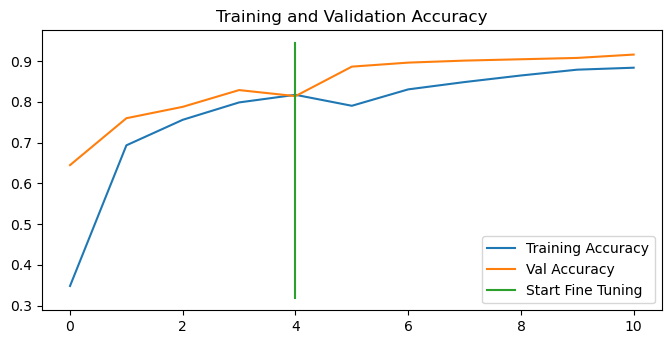

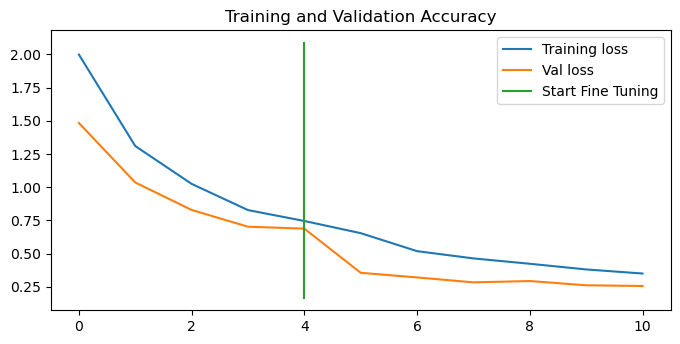

In [52]:
compare_historys(history_2,
                 history_4)

# 🛠 Excercise

## 1. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using `tf.keras.applications.EfficientNetB0` as the base model. Use the ModelCheckpoint callback to save the weights to file.

In [1]:
import tensorflow as tf

In [4]:
# Create training a test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [5]:
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [3]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint"

# Create a ModelCheckpoint callback that saves the model's weigths only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1)

In [6]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

In [8]:
# 2. Freeze the base model
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like ResNet50v2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)

# 6. Average pool the outputs of the base model (aggregate all the most importan information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_ex_1 = tf.keras.Model(inputs, outputs)

In [10]:
# Compile the model
model_ex_1.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss="categorical_crossentropy",
                   metrics=["accuracy"])

# Fit the model
initial_epochs = 10

history_ex_1 = model_ex_1.fit(train_data_10_percent,
                              epochs=initial_epochs,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              callbacks=[checkpoint_callback])

Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 1.9560 - accuracy: 0.3813
Epoch 1: saving model to ten_percent_model_checkpoints_weights\checkpoint
24/24 [==============================] - 34s 1s/step - loss: 1.9560 - accuracy: 0.3813 - val_loss: 1.3319 - val_accuracy: 0.7188
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 1.1163 - accuracy: 0.7840
Epoch 2: saving model to ten_percent_model_checkpoints_weights\checkpoint
24/24 [==============================] - 23s 968ms/step - loss: 1.1163 - accuracy: 0.7840 - val_loss: 0.8700 - val_accuracy: 0.8174
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.8022 - accuracy: 0.8227
Epoch 3: saving model to ten_percent_model_checkpoints_weights\checkpoint
24/24 [==============================] - 23s 966ms/step - loss: 0.8022 - accuracy: 0.8227 - val_loss: 0.7085 - val_accuracy: 0.8503
Epoch 4/10
24/24 [==============================] - ETA: 0s - loss: 0.6493 - accuracy: 0.8587
Epoch 4: 

In [11]:
evaluation_ex_1 = model_ex_1.evaluate(test_data)
evaluation_ex_1

79/79 [==============================] - 42s 525ms/step - loss: 0.4397 - accuracy: 0.8784


[0.4397439956665039, 0.8784000277519226]

## 2. Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs. How did it go?

In [13]:
base_model.trainable = True

# Freeze all layers except for the last 20
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Recompile 
model_ex_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                        loss="categorical_crossentropy",
                        metrics=["accuracy"])

In [16]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 10

# Refit the model (same as model_2 except with more trainable layers)
history_ex_2 = model_ex_1.fit(train_data_10_percent,
                              epochs=fine_tune_epochs,
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              initial_epoch=history_ex_1.epoch[-1])

Epoch 10/20


24/24 [==============================] - 35s 1s/step - loss: 0.7638 - accuracy: 0.8253 - val_loss: 0.4114 - val_accuracy: 0.8865
Epoch 11/20
24/24 [==============================] - 25s 1s/step - loss: 0.4929 - accuracy: 0.9240 - val_loss: 0.3859 - val_accuracy: 0.8832
Epoch 12/20
24/24 [==============================] - 25s 1s/step - loss: 0.3589 - accuracy: 0.9520 - val_loss: 0.3714 - val_accuracy: 0.8882
Epoch 13/20
24/24 [==============================] - 25s 1s/step - loss: 0.2855 - accuracy: 0.9600 - val_loss: 0.3604 - val_accuracy: 0.8997
Epoch 14/20
24/24 [==============================] - 25s 1s/step - loss: 0.2244 - accuracy: 0.9733 - val_loss: 0.3616 - val_accuracy: 0.8980
Epoch 15/20
24/24 [==============================] - 25s 1s/step - loss: 0.1911 - accuracy: 0.9773 - val_loss: 0.3497 - val_accuracy: 0.8980
Epoch 16/20
24/24 [==============================] - 25s 1s/step - loss: 0.1528 - accuracy: 0.9867 - val_loss: 0.3365 - val_accuracy: 0.9030
Epoch 17/20
24/24 [======

In [18]:
evaluation_ex_2 = model_ex_1.evaluate(test_data)
print("Model 1 accuracy: ",evaluation_ex_1[1])
print("Model 2 accuracy: ",evaluation_ex_2[1])

79/79 [==============================] - 39s 494ms/step - loss: 0.3502 - accuracy: 0.8896
Model 1 accuracy:  0.8784000277519226
Model 2 accuracy:  0.8895999789237976


## 3. Fine-tune the last 30 layers of the base model you trained in 2 for another 10 epochs. How did it go?

In [20]:
# Load weights from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
model_ex_1.load_weights(checkpoint_path)

In [21]:
model_ex_1.evaluate(test_data)

79/79 [==============================] - 40s 498ms/step - loss: 0.4397 - accuracy: 0.8784


[0.4397440552711487, 0.8784000277519226]

In [23]:
base_model.trainable = True

# Freeze all layers except for the last 20
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompile 
model_ex_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                        loss="categorical_crossentropy",
                        metrics=["accuracy"])

In [24]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 10

# Refit the model (same as model_2 except with more trainable layers)
history_ex_3 = model_ex_1.fit(train_data_10_percent,
                              epochs=fine_tune_epochs,
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              initial_epoch=history_ex_1.epoch[-1])

Epoch 10/20
24/24 [==============================] - 35s 1s/step - loss: 0.8363 - accuracy: 0.8040 - val_loss: 0.3977 - val_accuracy: 0.8832
Epoch 11/20
24/24 [==============================] - 25s 1s/step - loss: 0.5219 - accuracy: 0.9013 - val_loss: 0.3712 - val_accuracy: 0.8947
Epoch 12/20
24/24 [==============================] - 25s 1s/step - loss: 0.3779 - accuracy: 0.9493 - val_loss: 0.3877 - val_accuracy: 0.8783
Epoch 13/20
24/24 [==============================] - 25s 1s/step - loss: 0.2951 - accuracy: 0.9533 - val_loss: 0.3651 - val_accuracy: 0.8898
Epoch 14/20
24/24 [==============================] - 25s 1s/step - loss: 0.2340 - accuracy: 0.9680 - val_loss: 0.3538 - val_accuracy: 0.8997
Epoch 15/20
24/24 [==============================] - 25s 1s/step - loss: 0.1988 - accuracy: 0.9760 - val_loss: 0.3582 - val_accuracy: 0.8865
Epoch 16/20
24/24 [==============================] - 25s 1s/step - loss: 0.1459 - accuracy: 0.9907 - val_loss: 0.3308 - val_accuracy: 0.8914
Epoch 17/20
2

In [25]:
evaluation_ex_3 = model_ex_1.evaluate(test_data)
print("Model 1 accuracy: ",evaluation_ex_1[1])
print("Model 2 accuracy: ",evaluation_ex_2[1])
print("Model 3 accuracy: ",evaluation_ex_3[1])

79/79 [==============================] - 42s 525ms/step - loss: 0.3582 - accuracy: 0.8856
Model 1 accuracy:  0.8784000277519226
Model 2 accuracy:  0.8895999789237976
Model 3 accuracy:  0.8855999708175659


Conclusion: the best model is model 2 since it's accuracy score is the best and don't overfit as model 3

## Prediciendo con el modelo en funcionamiento

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def predict_random_image_with_class_names(dataset, model, class_names):
    # Select a random batch from the dataset
    for images, labels in dataset.take(1):
        # Select a random image from that batch
        random_index = np.random.randint(0, len(images))
        random_image = images[random_index]
        real_label = labels[random_index]
        
        # Display the image
        plt.imshow(random_image.numpy().astype("uint8"))
        plt.axis("off")
        plt.show()
        
        # Prepare the image for the model
        image_for_prediction = tf.expand_dims(random_image, 0)
        
        # Make a prediction
        predictions = model.predict(image_for_prediction)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        predicted_class_name = class_names[predicted_class_index]
        
        # Get the real class name
        real_class_index = np.argmax(real_label)
        real_class_name = class_names[real_class_index]
        
        # Check if the prediction is correct
        correct = predicted_class_index == real_class_index
        
        # Print the result
        if correct:
            print(f"\033[92mTrue, predicted class: {predicted_class_name}\033[0m")  # Text in green
        else:
            print(f"\033[91mFalse, predicted class: {predicted_class_name}, real class: {real_class_name}\033[0m")  # Text in red


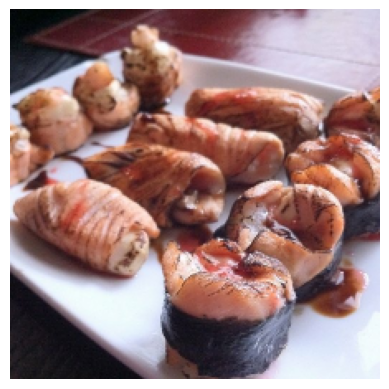

1/1 [==============================] - 0s 42ms/step
True, predicted class: sushi


In [83]:
predict_random_image_with_class_names(train_data_10_percent, model_ex_1, train_data_10_percent.class_names)